In [34]:
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt

In [112]:
from src.model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from src.least_volume_image import DCDiscriminator, TrueSNDCGenerator, TrueSNDCGeneratorSig, AutoEncoder, DynamicPruningAE_v2, \
    DynamicPruningAE_BCEv2, DynamicPruningAE_BCEO, DynamicPruningAE_v3, Adam, read_configs
from src.dataset.images import MNISTImages, CIFAR10Images
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from math import sqrt

In [39]:
mnist_train = next(iter(DataLoader(MNISTImages(True, device='cuda:6'), batch_size=60000)))
mnist_test = next(iter(DataLoader(MNISTImages(False, device='cuda:6'), batch_size=10000)))

In [37]:
path = '../saves/image/mnist/dp_0.001/'
configs = read_configs('mnist_dp', src=path)
ae = DynamicPruningAE_BCEv2(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:6')
ae.load(path + 'dp_mnist1999.tar')

# configs = read_configs('mnist_20', src='../src/')
# ae = DynamicPruningAE_v3(configs, DCDiscriminator, TrueSNDCGenerator, Adam).to('cuda:5')
# ae.load('../saves/image/mnist/dp_1e-04/dp_mnist20000.tar')
ae.eval()

DynamicPruningAE_BCEv2(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): Linear(in_features=102

tensor([7.4296e+01, 6.5528e+01, 6.0469e+01, 4.8626e+01, 3.6039e+01, 3.3024e+01,
        2.4708e+01, 2.4453e+01, 2.3100e+01, 2.0356e+01, 1.9972e+01, 1.9109e+01,
        1.8722e+01, 1.7831e+01, 1.6867e+01, 1.4160e+01, 1.4046e+01, 1.1594e+01,
        1.0724e+01, 1.0393e+01, 9.0533e+00, 8.1341e+00, 7.4912e+00, 6.2300e+00,
        4.3852e-03, 7.2932e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

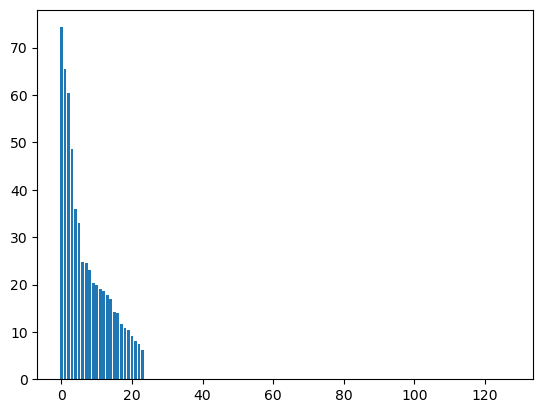

In [40]:
ss = ae.encode(mnist_train).std(0).sort()[0].flip(0).detach().cpu()
plt.bar(range(len(ss)), ss)
ss

In [42]:
with torch.no_grad():
    rec = ae.decode(ae.encode(mnist_train))
    print(l2_loss(rec, mnist_train))

tensor(1.7958, device='cuda:6')


In [43]:
mse_loss(rec, mnist_train)

tensor(0.0036, device='cuda:6')

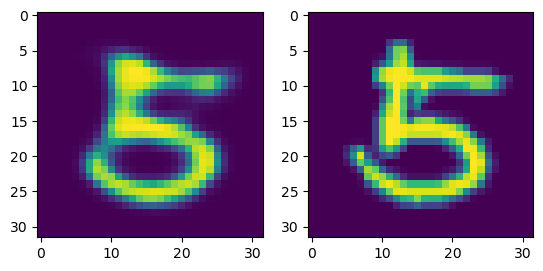

In [57]:
i = 10008
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i, 0].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_train[i, 0].detach().cpu())

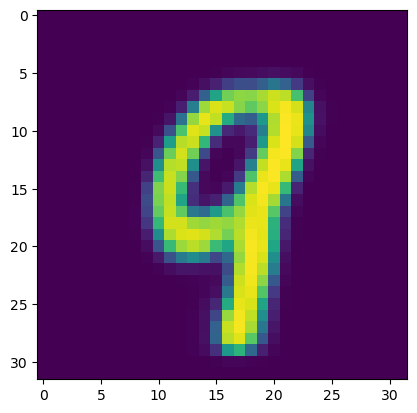

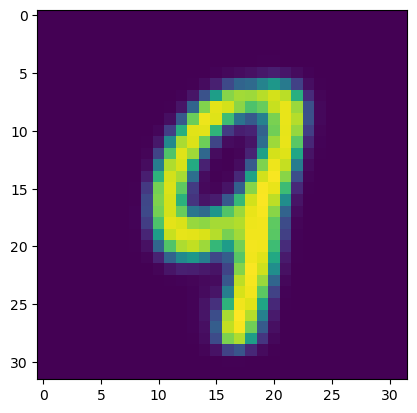

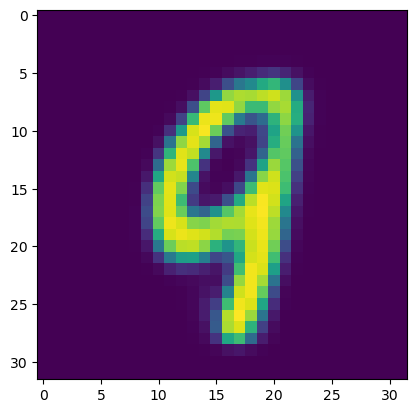

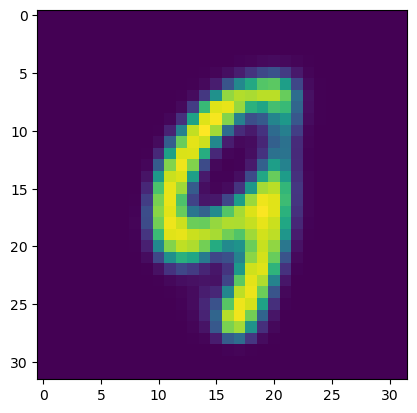

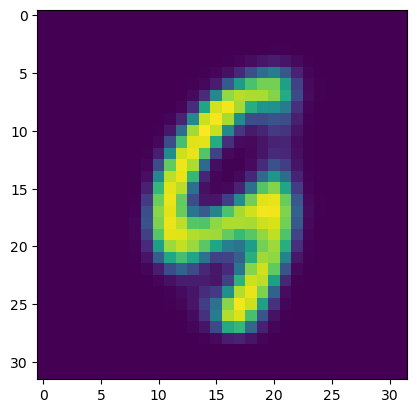

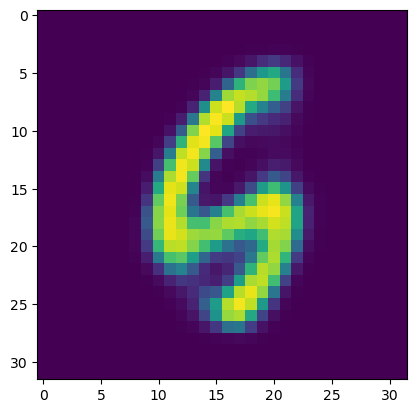

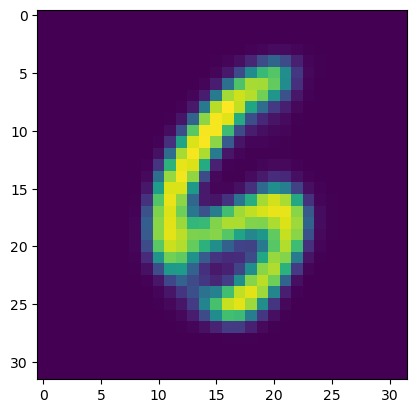

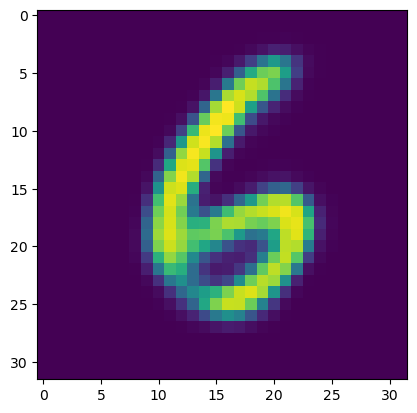

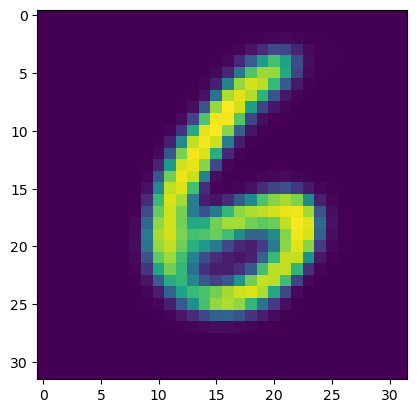

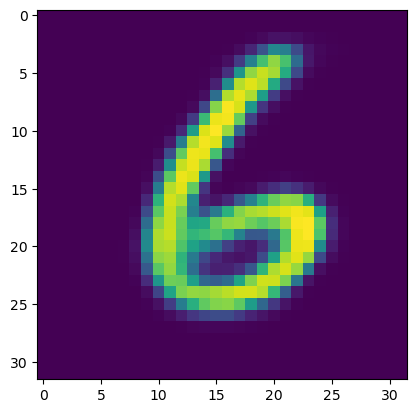

In [53]:
i = 6000; j = 800
for ff in np.linspace(0, 1, 10):
    z_m = (ae.encode(mnist_train[[i, j]]) * torch.as_tensor([ff, 1-ff], dtype=torch.float).reshape(2, 1).to('cuda:6')).sum(0, keepdim=True)
    plt.imshow(ae.decode(z_m)[0, 0].detach().cpu())
    plt.show()

In [59]:
with torch.no_grad():
    rect = ae.decode(ae.encode(mnist_test))
    print(l2_loss(rect, mnist_test))

tensor(1.7760, device='cuda:6')


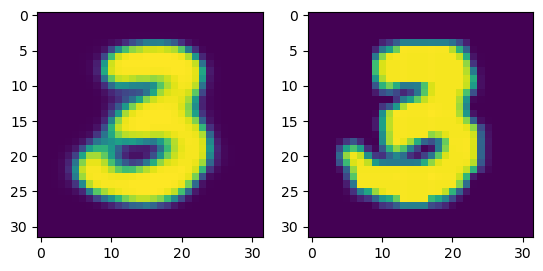

In [60]:
i = 200
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[i, 0].clip(0, 1).detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_test[i, 0].detach().cpu())

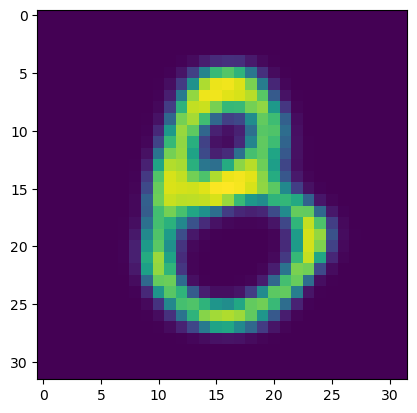

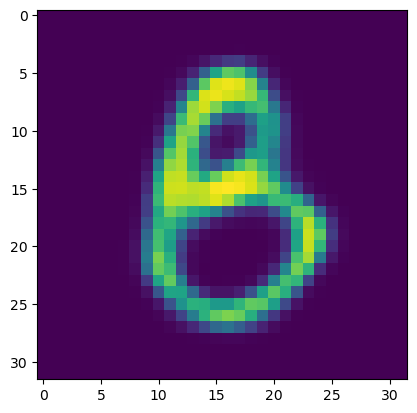

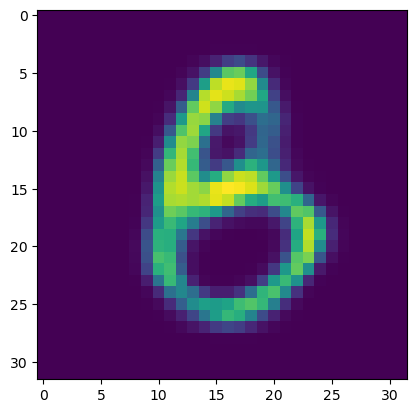

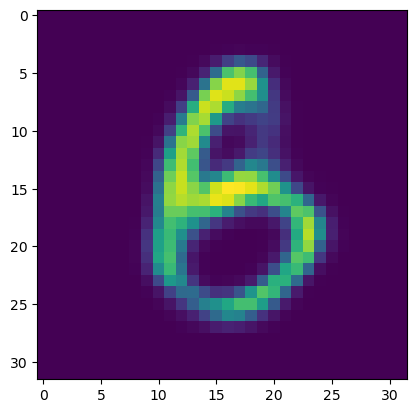

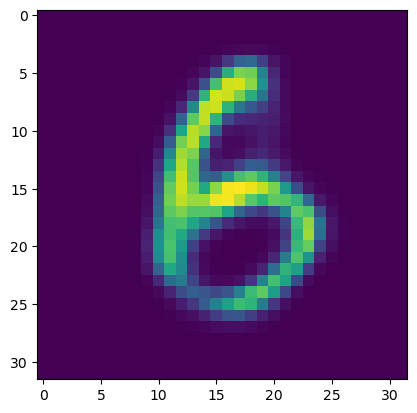

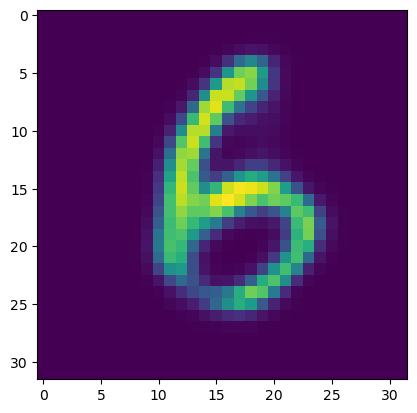

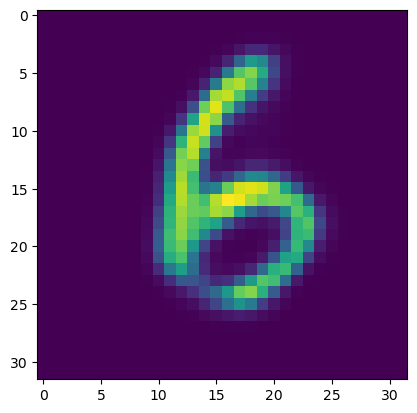

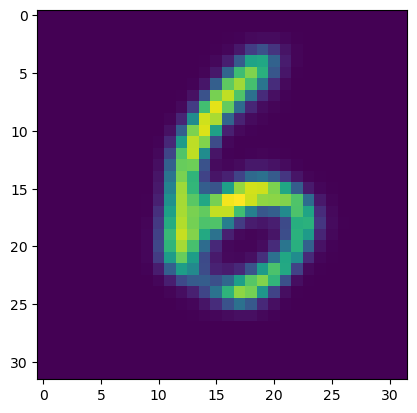

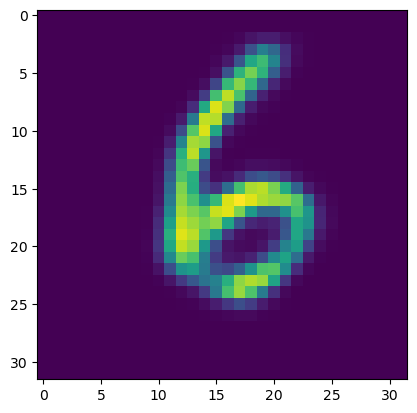

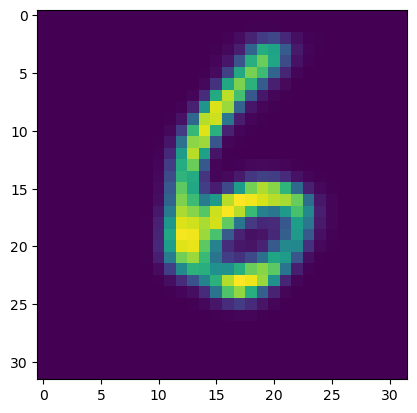

In [62]:
i = 2000; j = 800
for ff in np.linspace(0, 1, 10):
    z_m = (ae.encode(mnist_test[[i, j]]) * torch.as_tensor([ff, 1-ff], dtype=torch.float).reshape(2, 1).to('cuda:6')).sum(0, keepdim=True)
    plt.imshow(ae.decode(z_m)[0, 0].detach().cpu())
    plt.show()

# CIFAR10

In [111]:
cifar_train = torch.as_tensor(CIFAR10Images(True).images.data).to('cuda:6') / 255
cifar_test = torch.as_tensor(CIFAR10Images(False).images.data).to('cuda:6') / 255

Files already downloaded and verified
Files already downloaded and verified


In [314]:
path = '../saves/image/cifar10/dp_0.0003/'
configs = read_configs('cifar10_dp', src=path)
# ae = AutoEncoder(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:6')
ae = DynamicPruningAE_BCEO(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to('cuda:6')
ae.load(path + 'dp_cifar10799.tar')
ae.eval()

DynamicPruningAE_BCEO(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): Linear(in_features

In [315]:
with torch.no_grad():
    rec = ae.decode(ae.encode(cifar_train.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
    print(l2_loss(rec, cifar_train))

tensor(1.3100, device='cuda:6')


<BarContainer object of 2048 artists>

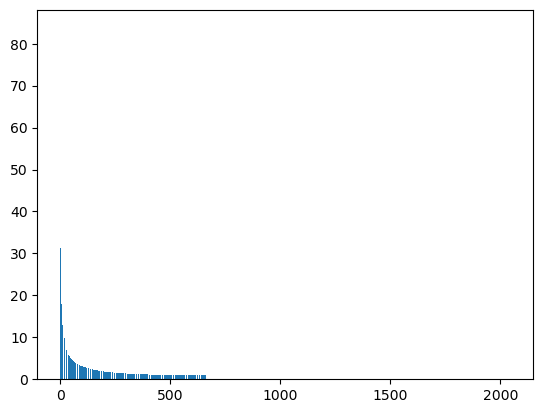

In [432]:
with torch.no_grad():
    z_tr = ae.encode(cifar_train.permute(0, 3, 2, 1))
    std, idx = z_tr.std(0).sort()
    mean = z_tr.mean(0)[idx]
    ss = std.flip(0).cpu()
plt.bar(range(len(ss)), ss)

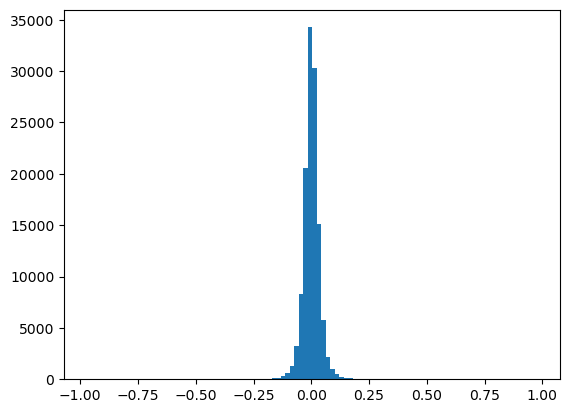

In [446]:
corr = z_tr[:, idx[-500:]].T.corrcoef().triu(1).flatten().cpu().numpy()
plt.hist(corr[corr != 0], bins=100)
plt.show()

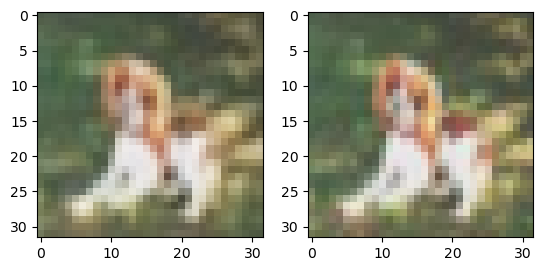

In [317]:
i=1033
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_train[i].detach().cpu())

In [341]:
dd = 1804
with torch.no_grad():
    z = ae.encode(cifar_train.permute(0, 3, 2, 1))
    # z[:, idx[:dd]] = mean[:dd]
    z[:, idx[-70]] = mean[-70]
    rec_p = ae.decode(z).permute(0, 3, 2, 1)
    print(l2_loss(rec_p, cifar_train))

tensor(1.4243, device='cuda:6')


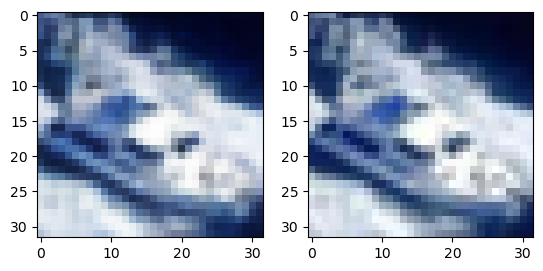

In [342]:
i=10004
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec_p[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_train[i].detach().cpu())

In [123]:
with torch.no_grad():
    rect = ae.decode(ae.encode(cifar_test.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
    print(l2_loss(rect, cifar_test))

tensor(1.5124, device='cuda:6')


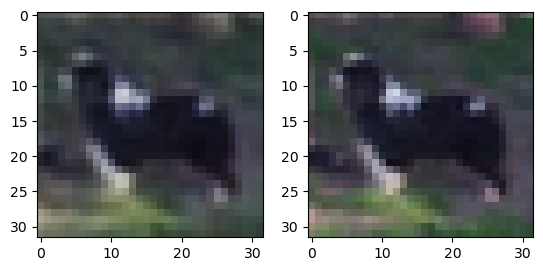

In [136]:
i = 1042
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_test[i].detach().cpu())

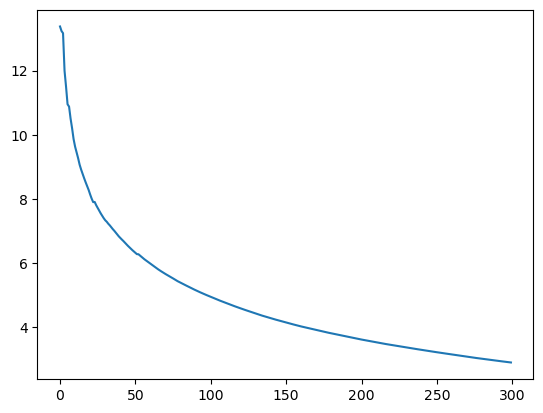

In [400]:
l2s = []

for d in range(300): 
    dd = 2048 - d
    with torch.no_grad():
        z = ae.encode(cifar_test.permute(0, 3, 2, 1))
        z[:, idx[:dd]] = mean[:dd]
        # z[:, idx[-2]] = mean[-2]
        rect_p = ae.decode(z).permute(0, 3, 2, 1)
        l2s.append(l2_loss(rect_p, cifar_test).cpu().numpy())

plt.plot(np.arange(300), np.asarray(l2s))

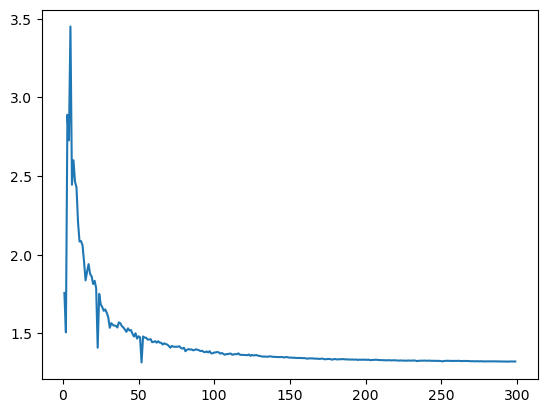

In [402]:
l2s = []

for d in range(1, 300): 
    with torch.no_grad():
        z = ae.encode(cifar_test.permute(0, 3, 2, 1))
        z[:, idx[-d]] = mean[-d]
        rect_p = ae.decode(z).permute(0, 3, 2, 1)
        l2s.append(l2_loss(rect_p, cifar_test).cpu().numpy())

plt.plot(np.arange(1, 300), np.asarray(l2s))

(0.0, 4.0)

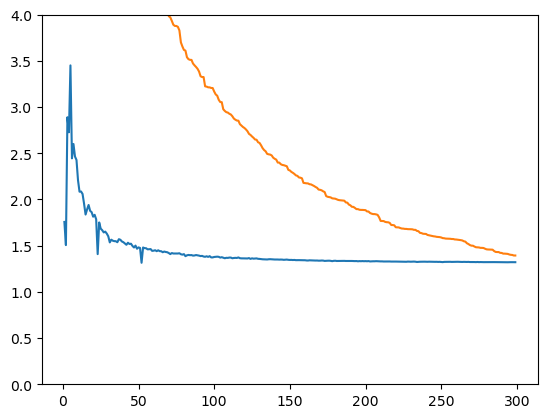

In [416]:
plt.plot(np.arange(1, 300), np.asarray(l2s))
plt.plot(np.arange(1, 300), ss[:299])
plt.ylim(0, 4)

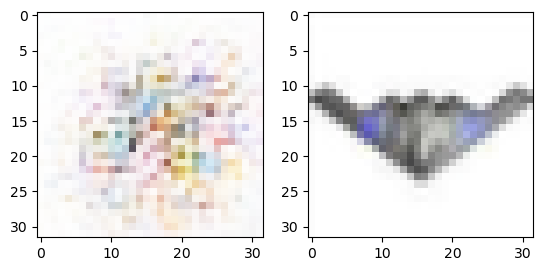

In [378]:
i = 6003
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect_p[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_test[i].detach().cpu())